# Использование предварительно обученной CNN

## Используемые библиотеки

In [104]:
import keras
import shutil, os
from keras.applications.vgg16 import VGG16
import numpy as np
from keras import layers
from keras import Sequential
from keras import optimizers
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

## Константы

In [105]:
BATCH_SIZE = 20
TRAIN_PATH = os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog', 'learn', 'train')
TEST_PATH = os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog', 'learn', 'test')
VAL_PATH = os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog', 'learn', 'val')

## Экземпляр сверточной основы VGG16

In [108]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

In [109]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Пути использования готовой сверточной основы

1. Выделение признаков
    - Менее энергозатратный: Преобразовать датасет при помощи готовой сверточной основы и обучить простую полносвязную сеть
    - Более энергозатратный: Поверх сверточной сети добавить полносвязный классификатор
2. Дообучение

## Выделение признаков

### Путь 0. Менее энергозатратный

#### Формируем фичи

In [110]:
#!g2.mig

def extract_features(directory: str, sample_count: int):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # Последние 3 значения соответсвуют форме выходу сверточной основы
    labels = np.zeros(shape=(sample_count))
    
    conv_base = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )
    
    datagen = ImageDataGenerator(rescale=1/255)
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        
        features[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = features_batch
        labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = labels_batch
        
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    
    return features, labels

In [111]:
#!g2.mig

train_features, train_labels = extract_features(TRAIN_PATH, 2000)
val_features, val_labels = extract_features(VAL_PATH, 1000)
test_features, test_labels = extract_features(TEST_PATH, 1000)

2023-02-06 19:31:12.073669: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 19:31:12.522040: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2629 MB memory:  -> device: 0, name: GRID A100X-1-5C MIG 1g.5gb, pci bus id: 0000:8c:00.0, compute capability: 8.0
2023-02-06 19:31:13.863810: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-06 19:31:14.516686: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2023-02-06 19:31:16.236418: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [112]:
#!g2.mig

train_features = train_features.reshape(2_000, 4 * 4 * 512)
val_features = val_features.reshape(1_000, 4 * 4 * 512)
test_features = test_features.reshape(1_000, 4 * 4 * 512)

#### Создаем классификтор

In [113]:
#!g2.mig

model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(8192,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [114]:
#!g2.mig
history = model.fit(
    train_features,
    train_labels,
    epochs=30,
    validation_data=(val_features, val_labels)
)

2023-02-06 19:31:51.542572: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 1/30
63/63 [==============================] - 1s 6ms/step - loss: 0.8610 - acc: 0.7250 - val_loss: 0.8307 - val_acc: 0.6640
Epoch 2/30
63/63 [==============================] - 0s 4ms/step - loss: 0.4098 - acc: 0.8185 - val_loss: 0.3044 - val_acc: 0.8520
Epoch 3/30
63/63 [==============================] - 0s 4ms/step - loss: 0.3522 - acc: 0.8530 - val_loss: 0.3231 - val_acc: 0.8590
Epoch 4/30
63/63 [==============================] - 0s 4ms/step - loss: 0.2927 - acc: 0.8775 - val_loss: 0.2789 - val_acc: 0.8850
Epoch 5/30
63/63 [==============================] - 0s 4ms/step - loss: 0.2492 - acc: 0.8945 - val_loss: 0.5421 - val_acc: 0.8110
Epoch 6/30
63/63 [==============================] - 0s 4ms/step - loss: 0.2399 - acc: 0.9005 - val_loss: 0.2703 - val_acc: 0.8900
Epoch 7/30
63/63 [==============================] - 0s 4ms/step - loss: 0.1938 - acc: 0.9220 - val_loss: 0.5975 - val_acc: 0.8060
Epoch 8/30
63/63 [==============================] - 0s 4ms/step - loss: 0.1680 - acc: 0.94

In [115]:
history_dict = history.history

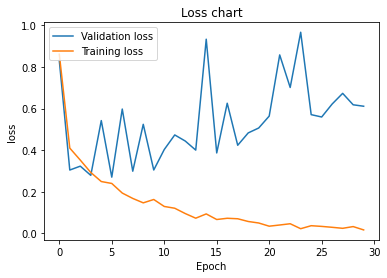

In [116]:
epochs = range(len(history_dict['val_loss']))

fig, ax = plt.subplots()

ax.plot(epochs, history_dict['val_loss'], label='Validation loss')
ax.plot(epochs, history_dict['loss'], label='Training loss')
ax.set(xlabel='Epoch', ylabel='loss', title='Loss chart')

plt.legend()
plt.show()

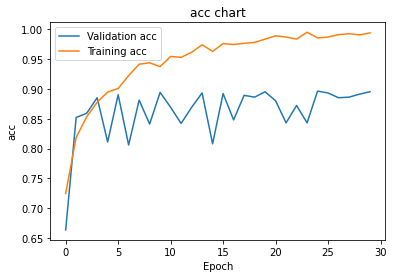

In [117]:
epochs = range(len(history_dict['val_acc']))

fig, ax = plt.subplots()

ax.plot(epochs, history_dict['val_acc'], label='Validation acc')
ax.plot(epochs, history_dict['acc'], label='Training acc')
ax.set(xlabel='Epoch', ylabel='acc', title='acc chart')

plt.legend()
plt.show()

#### Выводы

Заметно значительное повышение качества модели
- Точность повысилась до 0.9
- Потери около 0.8

Заметен эффект переобучения на первых эпохах. Модели не хвататет данных

### Путь 1. Энергозатраный

In [118]:
#!g2.mig
train_data = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_data = ImageDataGenerator(rescale=1/255)

In [119]:
#!g2.mig
train_generator = train_data.flow_from_directory(
    TRAIN_PATH,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
valid_generator = train_data.flow_from_directory(
    VAL_PATH,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_generator = test_data.flow_from_directory(
    TEST_PATH,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [120]:
#!g2.mig

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

2023-02-06 19:33:09.848609: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 19:33:10.296484: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2629 MB memory:  -> device: 0, name: GRID A100X-1-5C MIG 1g.5gb, pci bus id: 0000:8c:00.0, compute capability: 8.0


In [121]:
#!g2.mig

model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', input_shape=(8192,)))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [122]:
#!g2.mig

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [123]:
#!g2.mig

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=valid_generator,
    validation_steps=50
)

2023-02-06 19:33:14.233829: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-06 19:33:15.458422: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2023-02-06 19:33:17.163672: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-06 19:33:17.163739: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-06 19:33:18.099203: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying t

Epoch 1/50
100/100 [==============================] - 23s 175ms/step - loss: 0.7601 - acc: 0.6875 - val_loss: 0.7498 - val_acc: 0.6150
Epoch 2/50
100/100 [==============================] - 16s 158ms/step - loss: 0.5015 - acc: 0.7685 - val_loss: 0.5278 - val_acc: 0.7390
Epoch 3/50
100/100 [==============================] - 14s 143ms/step - loss: 0.4641 - acc: 0.7915 - val_loss: 0.7884 - val_acc: 0.6670
Epoch 4/50
100/100 [==============================] - 15s 143ms/step - loss: 0.4414 - acc: 0.8045 - val_loss: 0.4013 - val_acc: 0.8120
Epoch 5/50
100/100 [==============================] - 14s 145ms/step - loss: 0.4150 - acc: 0.8055 - val_loss: 0.5087 - val_acc: 0.7690
Epoch 6/50
100/100 [==============================] - 14s 144ms/step - loss: 0.4072 - acc: 0.8180 - val_loss: 0.3359 - val_acc: 0.8450
Epoch 7/50
100/100 [==============================] - 14s 144ms/step - loss: 0.3773 - acc: 0.8235 - val_loss: 0.3847 - val_acc: 0.8200
Epoch 8/50
100/100 [==============================] - 1

In [124]:
history_dict = history.history

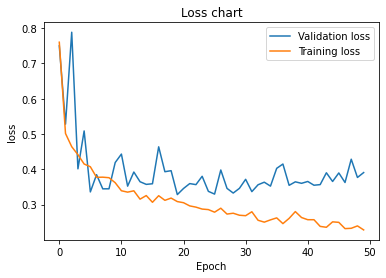

In [125]:
epochs = range(len(history_dict['val_loss']))

fig, ax = plt.subplots()

ax.plot(epochs, history_dict['val_loss'], label='Validation loss')
ax.plot(epochs, history_dict['loss'], label='Training loss')
ax.set(xlabel='Epoch', ylabel='loss', title='Loss chart')

plt.legend()
plt.show()

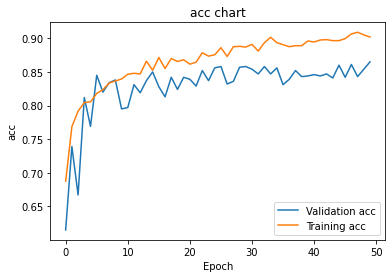

In [126]:
epochs = range(len(history_dict['val_acc']))

fig, ax = plt.subplots()

ax.plot(epochs, history_dict['val_acc'], label='Validation acc')
ax.plot(epochs, history_dict['acc'], label='Training acc')
ax.set(xlabel='Epoch', ylabel='acc', title='acc chart')

plt.legend()
plt.show()

#### Выводы

Повышение качества модели не значительное

## Дообучение

In [127]:
#!g2.mig

train_data = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_data = ImageDataGenerator(rescale=1/255)

In [128]:
#!g2.mig

train_generator = train_data.flow_from_directory(
    TRAIN_PATH,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
valid_generator = train_data.flow_from_directory(
    VAL_PATH,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_generator = test_data.flow_from_directory(
    TEST_PATH,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [129]:
#!g2.mig

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

2023-02-06 19:59:43.752580: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 19:59:44.201640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2629 MB memory:  -> device: 0, name: GRID A100X-1-5C MIG 1g.5gb, pci bus id: 0000:8c:00.0, compute capability: 8.0


In [130]:
#!g2.mig

model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', input_shape=(8192,)))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [131]:
#!g2.mig

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=50
)

2023-02-06 19:59:49.860099: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-02-06 19:59:51.048329: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2023-02-06 19:59:52.779068: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-06 19:59:52.779146: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-06 19:59:53.714660: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

100/100 [==============================] - 23s 176ms/step - loss: 0.7767 - acc: 0.6830 - val_loss: 0.6574 - val_acc: 0.6510
Epoch 2/30
100/100 [==============================] - 16s 157ms/step - loss: 0.4833 - acc: 0.7830 - val_loss: 0.7855 - val_acc: 0.6330
Epoch 3/30
100/100 [==============================] - 14s 144ms/step - loss: 0.4434 - acc: 0.7970 - val_loss: 0.6931 - val_acc: 0.6660
Epoch 4/30
100/100 [==============================] - 14s 144ms/step - loss: 0.4392 - acc: 0.8030 - val_loss: 0.4593 - val_acc: 0.7820
Epoch 5/30
100/100 [==============================] - 14s 143ms/step - loss: 0.4077 - acc: 0.8045 - val_loss: 0.4058 - val_acc: 0.8170
Epoch 6/30
100/100 [==============================] - 14s 143ms/step - loss: 0.4033 - acc: 0.8100 - val_loss: 0.4374 - val_acc: 0.7790
Epoch 7/30
100/100 [==============================] - 14s 144ms/step - loss: 0.3833 - acc: 0.8435 - val_loss: 0.3577 - val_acc: 0.8210
Epoch 8/30
100/100 [==============================] - 14s 142ms/st

Замораживание всех слоев, кроме 3 последних в сверточной сети

In [135]:
#!g2.mig
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    layer.trainable = set_trainable

In [136]:
#!g2.mig
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [137]:
#!g2.mig

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=valid_generator,
    validation_steps=50
)

Epoch 1/100
100/100 [==============================] - 18s 161ms/step - loss: 82.5420 - acc: 0.5280 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 2/100
100/100 [==============================] - 14s 143ms/step - loss: 2.2595 - acc: 0.5060 - val_loss: 0.6912 - val_acc: 0.5000
Epoch 3/100
100/100 [==============================] - 15s 151ms/step - loss: 1.4812 - acc: 0.6045 - val_loss: 0.6522 - val_acc: 0.6240
Epoch 4/100
100/100 [==============================] - 14s 144ms/step - loss: 0.6627 - acc: 0.7185 - val_loss: 0.9977 - val_acc: 0.5780
Epoch 5/100
100/100 [==============================] - 15s 149ms/step - loss: 0.5738 - acc: 0.7510 - val_loss: 0.3913 - val_acc: 0.8020
Epoch 6/100
100/100 [==============================] - 14s 144ms/step - loss: 0.5571 - acc: 0.7890 - val_loss: 0.3516 - val_acc: 0.8410
Epoch 7/100
100/100 [==============================] - 15s 149ms/step - loss: 0.4510 - acc: 0.8265 - val_loss: 0.3803 - val_acc: 0.8560
Epoch 8/100
100/100 [==========================

In [138]:
history_dict = history.history

2023-02-06 20:40:57.847636: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2023-02-06 20:40:57.847666: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-06 20:40:57.847682: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (s-2dcb4d6e-cff5-45a2-9954-e963cc5e0699): /proc/driver/nvidia/version does not exist
2023-02-06 20:40:57.847897: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

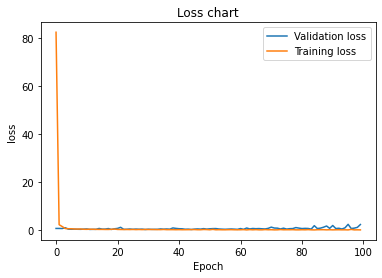

In [139]:
epochs = range(len(history_dict['val_loss']))

fig, ax = plt.subplots()

ax.plot(epochs, history_dict['val_loss'], label='Validation loss')
ax.plot(epochs, history_dict['loss'], label='Training loss')
ax.set(xlabel='Epoch', ylabel='loss', title='Loss chart')

plt.legend()
plt.show()

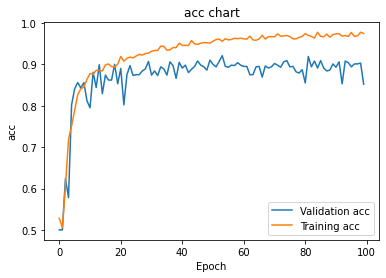

In [140]:
epochs = range(len(history_dict['val_acc']))

fig, ax = plt.subplots()

ax.plot(epochs, history_dict['val_acc'], label='Validation acc')
ax.plot(epochs, history_dict['acc'], label='Training acc')
ax.set(xlabel='Epoch', ylabel='acc', title='acc chart')

plt.legend()
plt.show()

### Вывод

Применение метода дообучения позволило увеличить качество модели с 0.85 до 0.9, что не очень существенно